In [1]:
#importing necessary libraries
import os 
import matplotlib.pylab as plt
import pandas as pd

import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics, linear_model
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential,Model
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate, Dropout
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
#reading the data
#reading the data
data_df=pd.read_csv("/content/test_scores.csv")
data_df.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


In [4]:
#checking the shape 
data_df.shape

(2133, 11)

In [6]:
data=data_df.copy()

In [4]:
data=pd.DataFrame(data_df,columns={'school','school_setting','school_type','classroom','teaching_method','n_student','student_id','gender','lunch','pretest','posttest'})

In [7]:
#separating dependent and independent features
target_features = ['posttest']
independent_features = ['school','school_setting','school_type','classroom','teaching_method','n_student','gender','lunch','pretest','student_id']

# **Splitting the data into Train/Test Split**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['posttest'], axis = 1), data['posttest'], random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1599, 10), (534, 10), (1599,), (534,))

# **Categorical Features Embedding Preparation**

In [9]:
#checking the number of categorical features in the data
categorical_columns=[i for i in X_train.select_dtypes(include=['object'])]

for i in categorical_columns:
    print(i,data[i].nunique())

school 23
school_setting 3
school_type 2
classroom 97
teaching_method 2
student_id 2133
gender 2
lunch 2


In [10]:
#Categorical features needs to be converted into list format to match the network structure

#Categorical Features To List Format
categorical_columns=[i for i in X_train.select_dtypes(include=['object'])]

#converting data to list format to match the network structure
def convertDataToList(X_train,X_test):

    input_train_list = []
    input_test_list = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for category in categorical_columns:
        unique_categorical_vals = np.unique(X_train[category])
        val_map = {}
        
        for i in range(len(unique_categorical_vals)):
            val_map[unique_categorical_vals[i]] = i   
        input_train_list.append(X_train[category].map(val_map).values)
        input_test_list.append(X_test[category].map(val_map).values)
     
    #the rest of the features other than categorical features
    other_cols = [c for c in X_train.columns if (not c in categorical_columns)]
    input_train_list.append(X_train[other_cols].values)
    input_test_list.append(X_test[other_cols].values)
    
    return input_train_list,input_test_list

In [11]:
input_train_list,input_test_list=convertDataToList(X_train,X_test)


In [12]:
input_models=[]
output_embeddings=[]
numerical_features = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for categorical_var in X_train.select_dtypes(include=['object']):
    
    #Name of the categorical variable that will be used in the Keras Embedding layer
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    # Define the embedding_size
    no_of_unique_cat  = X_train[categorical_var].nunique()
   # embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
    embedding_size=50
  
    #One Embedding Layer for each categorical variable
    input_model = Input(shape=(1,))
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size,))(output_model)    
  
    #Appending all the categorical inputs
    input_models.append(input_model)
  
    #Appending all the embeddings
    output_embeddings.append(output_model)
  
#Other non-categorical data columns (numerical). 
#I define single another network for the other columns and add them to our models list.
input_numeric = Input(shape=(len(X_train.select_dtypes(include=numerical_features).columns.tolist()),))
embedding_numeric = Dense(128)(input_numeric) 
input_models.append(input_numeric)
output_embeddings.append(embedding_numeric)

#At the end we concatenate altogther and add other Dense layers
output = Concatenate()(output_embeddings)
output = Dense(1000, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.4)(output)
output = Dense(512, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.3)(output)
output = Dense(1, activation='sigmoid')(output)

model = Model(inputs=input_models, outputs=output)
model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mse','mape'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [14]:
input_train_list,input_test_list=convertDataToList(X_train,X_test)


In [15]:
history  =  model.fit(input_train_list,y_train,validation_data=(input_test_list, y_test) , epochs =  500 , batch_size = 512, verbose= 2)

Epoch 1/500
4/4 - 17s - loss: 4570.2021 - mse: 4570.2021 - mape: 98.6824 - val_loss: 4609.0430 - val_mse: 4609.0430 - val_mape: 98.4477
Epoch 2/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.3447 - mape: 98.4361 - val_loss: 4609.0430 - val_mse: 4609.0430 - val_mape: 98.4477
Epoch 3/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.3447 - mape: 98.4361 - val_loss: 4609.0430 - val_mse: 4609.0430 - val_mape: 98.4477
Epoch 4/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.3447 - mape: 98.4361 - val_loss: 4609.0430 - val_mse: 4609.0430 - val_mape: 98.4477
Epoch 5/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.3447 - mape: 98.4360 - val_loss: 4609.0430 - val_mse: 4609.0430 - val_mape: 98.4477
Epoch 6/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.3447 - mape: 98.4361 - val_loss: 4609.0430 - val_mse: 4609.0430 - val_mape: 98.4477
Epoch 7/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.3447 - mape: 98.4361 - val_loss: 4609.0430 - val_mse: 4609.0430 - val_mape: 98.4477
Epoch 8/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.344

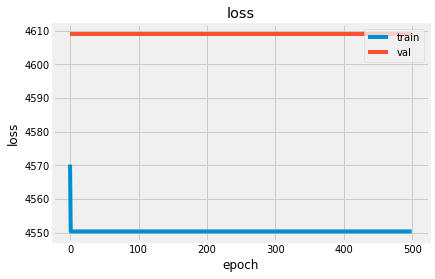

In [16]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
